# Imports

In [2]:
%load_ext autoreload
%autoreload 2

import os
import math

import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import pandas as pd
import dask
from tqdm import tqdm

import vector
import particle
import hepunits

import comet_ml
import zuko
import torch
from torch import nn, optim
import lightning as L
from lightning.pytorch import loggers as pl_loggers
from torch.utils.data import DataLoader, Subset
from torch.optim.lr_scheduler import SequentialLR, LambdaLR, CosineAnnealingLR

import multiprocessing
import uuid

from memflow.dataset.data import ParquetData
from memflow.dataset.dataset import CombinedDataset
from memflow.ttH.ttH_dataclasses import ttHHardDataset, ttHRecoDataset

from memflow.ttH.models.ParallelTransfusion import StandardCFM, OptimalTransportCFM, TargetBridgingCFM, SchrodingerBridgeCFM, VariancePreservingCFM
from models.utils import plot_trajectories_2d, compare_distributions, save_samples, load_samples, plot_trajectories_grid
from models.callbacks import CFMSamplingCallback, SamplingCallback, BiasCallback

from transfer_flow.transfer_flow_model import *
from transfer_flow.custom_flows import *

vector.register_awkward()

num_workers = min(16, multiprocessing.cpu_count())  # Use up to 16 CPU cores
print(f'Number of CPU workers for dataloading: {num_workers}')
os.environ["CUDA_VISIBLE_DEVICES"] = "5"  # Change "<n>" to the index of the GPU you want to use on node

print (f"Running on GPU : {torch.cuda.is_available()}")
accelerator = 'cuda' if torch.cuda.is_available() else 'cpu'
print (f"Accelerator : {accelerator}")
torch.set_float32_matmul_precision('medium')
if accelerator =='cuda':
    torch.cuda.empty_cache()
    print (torch.cuda.memory_summary(device=None, abbreviated=True))

/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(
2025-02-25 12:47:42.452718: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-25 12:47:42.452786: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-25 12:47:42.452808: E tensorflow/c

Number of CPU workers for dataloading: 16
Running on GPU : True
Accelerator : cuda
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Requested memory      |      0 B   |      0 B   |      0 

# Data

In [3]:
data_hard = ParquetData(
    files = [
        '/cephfs/dice/users/sa21722/datasets/MEM_data/ttH/TF_v6/hard/2018/ttH/ttH_HToInvisible_M125.parquet',
        #'all_jets_fullRun2_ttHbb_forTraining_allyears_spanetprov_part1_validation.parquet',
        #'all_jets_fullRun2_ttHTobb_forTraining_2016_PreVFP_v3.parquet',
    ],
    lazy = True,
    # N = int(1e5),
)

print (data_hard)

Data object
Loaded branches:
   ... file: 1903554
   ... sample: 1903554
   ... tree: 1903554
Branch in files not loaded:
   ... Generator_scalePDF
   ... Generator_weight
   ... Generator_x1
   ... Generator_x2
   ... Generator_xpdf1
   ... Generator_xpdf2
   ... W_minus_from_antitop_eta
   ... W_minus_from_antitop_genPartIdxMother
   ... W_minus_from_antitop_idx
   ... W_minus_from_antitop_mass
   ... W_minus_from_antitop_pdgId
   ... W_minus_from_antitop_phi
   ... W_minus_from_antitop_pt
   ... W_minus_from_antitop_status
   ... W_minus_from_antitop_statusFlags
   ... W_plus_from_top_eta
   ... W_plus_from_top_genPartIdxMother
   ... W_plus_from_top_idx
   ... W_plus_from_top_mass
   ... W_plus_from_top_pdgId
   ... W_plus_from_top_phi
   ... W_plus_from_top_pt
   ... W_plus_from_top_status
   ... W_plus_from_top_statusFlags
   ... Z_from_higgs_eta
   ... Z_from_higgs_genPartIdxMother
   ... Z_from_higgs_idx
   ... Z_from_higgs_mass
   ... Z_from_higgs_pdgId
   ... Z_from_higgs_phi

# Hard dataset

In [4]:
hard_dataset = ttHHardDataset(
    data = data_hard,
    selection = [
        # 'higgs',
        # 'tops',
        'bottoms',
        # 'Ws',
        # 'Zs',
        'quarks',
        'neutrinos',
    ],
    build = False,
    fit = True,
    coordinates = 'cylindrical',
    apply_preprocessing = True,
    apply_boost = False,
    dtype = torch.float32,
)

print(hard_dataset)

Loading objects from /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_hard


Saving preprocessing to /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_hard
Will overwrite what is in output directory /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_hard/preprocessing
Preprocessing saved in /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_hard/preprocessing
Parton dataset with 756642 events
 Initial states pdgids : [21, 21]
 Final states pdgids   : [25, 6, -6]
 Final states masses   : [125.2, 172.57, 172.57]
Containing the following tensors
bottoms    : data ([756642, 2, 5]), mask ([756642, 2])
             Mask exist    : [100.00%, 100.00%]
             Mask attn     : [True, True]
             Weights       : 756642.00, 756642.00
             Features      : ['pt', 'eta', 'phi', 'mass', 'pdgId']
             Selected for batches : True
Zs         : data ([756642, 2, 5]), mask ([756642, 2])
             Mask exist    : [100.00%, 100.00%]
             Mask attn     : [True, True]
             Weights       : 756642.00, 756642.00
             F

# Reco dataset

In [5]:
data_reco = ParquetData(
    files = [
        '/cephfs/dice/users/sa21722/datasets/MEM_data/ttH/TF_v6/reco/2018/ttH/ttH_HToInvisible_M125.parquet',
    ],
    lazy = True,
    #N = data_hard.N,
)

print(data_reco)

Data object
Loaded branches:
   ... file: 231528
   ... sample: 231528
   ... tree: 231528
Branch in files not loaded:
   ... Generator_scalePDF
   ... Generator_weight
   ... Generator_x1
   ... Generator_x2
   ... Generator_xpdf1
   ... Generator_xpdf2
   ... InputMet_phi
   ... InputMet_pt
   ... cleanedJet_btagDeepFlavB
   ... cleanedJet_eta
   ... cleanedJet_mass
   ... cleanedJet_phi
   ... cleanedJet_pt
   ... event
   ... ncleanedBJet
   ... ncleanedJet
   ... region
   ... weight_nominal
   ... xs_weight


Have a look at athe minimum values for Jet and MET pT in the raw dataset. This can give an indication as to what the cutoff in the SR is and hence what to set the `'pt':lowercutshift()` to in the pre-processing

In [6]:
reco_dataset = ttHRecoDataset(
    data = data_reco,
    selection = [
        'jets',
        'met',
    ],
    build = False,
    fit = True,
    coordinates = 'cylindrical',
    apply_preprocessing = True,
    apply_boost = False,
    dtype = torch.float32,
)
print(reco_dataset)

Loading objects from /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_reco
Saving preprocessing to /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_reco
Will overwrite what is in output directory /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_reco/preprocessing
Preprocessing saved in /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_reco/preprocessing
Reco dataset with 114647 events
Containing the following tensors
jets  : data ([114647, 6, 5]), mask ([114647, 6])
        Mask exist    : [100.00%, 100.00%, 100.00%, 100.00%, 100.00%, 62.85%]
        Mask attn     : [True, True, True, True, True, True]
        Weights       : 114647.00, 114647.00, 114647.00, 114647.00, 114647.00, 114647.00
        Features      : ['pt', 'eta', 'phi', 'mass', 'btag']
        Selected for batches : True
met   : data ([114647, 1, 4]), mask ([114647, 1])
        Mask exist    : [100.00%]
        Mask attn     : [True]
        Weights       : 114647.00
        Features      : ['pt

# Combined dataset

In [7]:
combined_dataset = CombinedDataset(
    hard_dataset=hard_dataset,
    reco_dataset=reco_dataset,
)
print(combined_dataset)

Intersection branches : `event` for hard dataset and `event` for reco dataset
Looking into file metadata
Will pair these files together :
   - /cephfs/dice/users/sa21722/datasets/MEM_data/ttH/TF_v6/hard/2018/ttH/ttH_HToInvisible_M125.parquet <-> /cephfs/dice/users/sa21722/datasets/MEM_data/ttH/TF_v6/reco/2018/ttH/ttH_HToInvisible_M125.parquet
For entry 0 : from 756642 events, 91819 selected
For entry 1 : from 114647 events, 91819 selected
Combined dataset (extracting 91819 events of the following) :
Parton dataset with 756642 events
 Initial states pdgids : [21, 21]
 Final states pdgids   : [25, 6, -6]
 Final states masses   : [125.2, 172.57, 172.57]
Containing the following tensors
bottoms    : data ([756642, 2, 5]), mask ([756642, 2])
             Mask exist    : [100.00%, 100.00%]
             Mask attn     : [True, True]
             Weights       : 756642.00, 756642.00
             Features      : ['pt', 'eta', 'phi', 'mass', 'pdgId']
             Selected for batches : True
Zs   

In [8]:
inference_loader = DataLoader(
    combined_dataset,
    batch_size = 10000,
    shuffle = False,
    num_workers = num_workers,
    pin_memory = True,
)

In [47]:
model = StandardCFM.load_from_checkpoint(checkpoint_path="parallel_transfusion_checkpoints/model_epoch_500.ckpt")
model.to(accelerator)
model.eval()

No hard attention mask provided; will use existence mask only.
Transformer args: will override `d_model` to 64
('pt', 'eta', 'phi', 'mass')
('pt', 'phi')


StandardCFM(
  (hard_embeddings): ModuleList(
    (0-2): 3 x Sequential(
      (0): CircularEmbedding(
        (linear): Linear(in_features=6, out_features=32, bias=True)
        (act): GELU(approximate='none')
      )
      (1): Linear(in_features=32, out_features=64, bias=True)
    )
  )
  (reco_embeddings): ModuleList(
    (0): Sequential(
      (0): CircularEmbedding(
        (linear): Linear(in_features=6, out_features=32, bias=True)
        (act): GELU(approximate='none')
      )
      (1): Linear(in_features=32, out_features=64, bias=True)
    )
    (1): Sequential(
      (0): CircularEmbedding(
        (linear): Linear(in_features=5, out_features=32, bias=True)
        (act): GELU(approximate='none')
      )
      (1): Linear(in_features=32, out_features=64, bias=True)
    )
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj)

# TransferCFM

In [ ]:
batch = next(iter(inference_loader))
batch = CFMSamplingCallback.move_batch_to_device(batch, model.device)

# Print the structure of the batch
print("Batch structure:")
for key in batch:
    print(f"{key}:")
    for sub_key, val in batch[key].items():
        if isinstance(val, list):
            print(f"  {sub_key}: {[v.shape for v in val]}")
        elif isinstance(val, torch.Tensor):
            print(f"  {sub_key}: {val.shape}")

traj_samples_file = "traj_samples.pt"
all_traj_file = "all_traj.pt"
if os.path.exists(os.path.join("saved_samples", traj_samples_file)) and os.path.exists(os.path.join("saved_samples", all_traj_file)):
    traj_samples = load_samples(traj_samples_file)
    all_traj = load_samples(all_traj_file)
else:
    with torch.no_grad():
        model = model.to(model.device)

        # Extract the necessary inputs for sampling
        hard_data = batch["hard"]["data"]
        hard_mask = batch["hard"]["mask"]
        reco_data = batch["reco"]["data"]
        reco_mask = batch["reco"]["mask"]

        print(f"Hard data batch size: {hard_data[0].shape[0]}")
        print(f"Reco data batch size: {reco_data[0].shape[0]}")

        traj_samples, all_traj = model.sample(
            hard_data,
            hard_mask,
            reco_data,
            reco_mask,
            N_sample=1000,
            steps=20,
            store_trajectories=True
        )
    save_samples(traj_samples, traj_samples_file)
    save_samples(all_traj, all_traj_file)
    # Took 12 mins for 100 samples

In [ ]:
# all_traj is the shape [N_sample, steps+1, B, sum_reco, 2], used for 2D trajectory plots
# Feature indexes:
#   Jets: "pt"=0, "eta"=1 "phi"=2
#   MET: "pt"=0, "phi"=1
plot_trajectories_2d(
    all_traj,
    model,
    type_idx = 1, # "Jets"=0, "met"=1
    feat_idx_x = 1,
    feat_idx_y = 0,
    num_events = 100,
    mode = "single_event",
    event_idx = 1,
    object_idx = 0,
    #preprocessing = combined_dataset.reco_dataset.preprocessing,
    batch=batch,
)
plot_trajectories_2d(
    all_traj,
    model,
    type_idx = 0, # "Jets"=0, "met"=1
    feat_idx_x = 1,
    feat_idx_y = 0,
    num_events = 100,
    mode = "single_event",
    event_idx = 325,
    object_idx = 0,
    #preprocessing = combined_dataset.reco_dataset.preprocessing,
    batch=batch,
)

In [ ]:
plot_trajectories_grid(
    all_traj,
    model,
    custom_timesteps=[4, 10, 20],
    type_idx=0,
    feat_idx_x=1,
    feat_idx_y=0,
    max_points=500,
    event_idx=57,
    object_idx=0,
    batch=batch,
    grid_size=14
)

# Main Distributions Plots

## Parallel Transfusion Model

In [44]:
samples_full_file = "PT_samples_full.pt"

if os.path.exists(os.path.join("saved_samples", samples_full_file)):
    samples_full = load_samples(samples_full_file)
else:
    train_frac = 0.8
    indices = torch.arange(len(combined_dataset))
    sep = int(train_frac*len(combined_dataset))
    valid_indices = indices[sep:]
    combined_dataset_valid = torch.utils.data.Subset(combined_dataset,valid_indices)
    print (f'Dataset : validation {len(combined_dataset_valid)}')

    # Use a DataLoader with batch_size=10 for testing (change as needed)
    full_loader = DataLoader(
        combined_dataset_valid,
        batch_size=1000,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )

    # Lists to accumulate outputs from each mini-batch
    samples_full_list = []

    with torch.no_grad():
        # Use enumerate to get the batch index along with the batch
        for batch_idx, batch in enumerate(tqdm(full_loader, desc="Processing full dataset")):

            # Move the batch to the appropriate device
            batch = CFMSamplingCallback.move_batch_to_device(batch, model.device)

            # Extract inputs for the sampling function
            hard_data = batch["hard"]["data"]
            hard_mask = batch["hard"]["mask"]
            reco_data = batch["reco"]["data"]
            reco_mask = batch["reco"]["mask"]

            # Run model sampling on the current batch
            samples_full = model.sample(
                hard_data,
                hard_mask,
                reco_data,
                reco_mask,
                N_sample=3,      # number of samples per event
                steps=20,
            )

            # Append outputs from this batch (each is a list of tensors)
            samples_full_list.append(samples_full)

    # Determine the number of elements per sample (assuming it's consistent across batches)
    num_items = len(samples_full_list[0])

    # Concatenate corresponding elements across batches along the batch dimension (dim=2)
    samples_full = [
        torch.cat([batch_output[i] for batch_output in samples_full_list], dim=1)
        for i in range(num_items)
    ]

    # Debugging prints
    print(f"Number of elements per sample: {num_items}")
    for i, sample in enumerate(samples_full):
        print(f"Sample {i}: {sample.shape}")

    # Save the concatenated results
    save_samples(samples_full, samples_full_file)

Samples loaded from saved_samples/PT_samples_full.pt


## Transfermer

In [54]:
transfermer_model = TransferFlow.load_from_checkpoint(
    checkpoint_path="TransferFlow_checkpoints/model_epoch_10.ckpt",
    encoder_embeddings=MultiEmbeddings(
        features_per_type=combined_dataset.hard_dataset.input_features,
        embed_dims=[32, 64],
        hidden_activation=nn.GELU,
    ),
    decoder_embeddings=MultiEmbeddings(
        features_per_type=combined_dataset.reco_dataset.input_features,
        embed_dims=[32, 64],
        hidden_activation=nn.GELU,
    ),
    transformer=Transformer(
        d_model=64,
        encoder_layers=6,
        decoder_layers=8,
        nhead=8,
        dim_feedforward=256,
        activation=nn.GELU,
        encoder_mask_attn=None,
        decoder_mask_attn=combined_dataset.reco_dataset.attention_mask,
        use_null_token=True,
        dropout=0.0,
    ),
    flow=KinematicFlow(
        d_model=64,
        flow_mode='global',
        flow_features=[
            ['pt', 'eta', 'phi', 'mass'],  # jets
            ['pt', 'phi'],  # met
        ],
        flow_classes={
            'pt': zuko.flows.NSF,
            'eta': UniformNSF,
            'phi': UniformNCSF,
            'mass': zuko.flows.NSF,
        },
        flow_common_args={
            'bins': 16,
            'transforms': 5,
            'randperm': True,
            'passes': None,
            'hidden_features': [256] * 3,
        },
        flow_specific_args={
            'eta': {'bound': 1.0},
            'phi': {'bound': math.pi},
        },
    ),
)
transfermer_model.to(accelerator)
transfermer_model.eval()


/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'encoder_embeddings' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_embeddings'])`.
/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'decoder_embeddings' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['decoder_embeddings'])`.
/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'transformer' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['transformer'])`.
/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10

TransferFlow(
  (encoder_embeddings): MultiEmbeddings(
    (embeddings): ModuleList(
      (0-2): 3 x MLP(
        (layers): Sequential(
          (0): Linear(in_features=5, out_features=32, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=32, out_features=64, bias=True)
        )
      )
    )
  )
  (decoder_embeddings): MultiEmbeddings(
    (embeddings): ModuleList(
      (0): MLP(
        (layers): Sequential(
          (0): Linear(in_features=5, out_features=32, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=32, out_features=64, bias=True)
        )
      )
      (1): MLP(
        (layers): Sequential(
          (0): Linear(in_features=4, out_features=32, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=32, out_features=64, bias=True)
        )
      )
    )
  )
  (transformer): Transformer(
    (transformer): Transformer(
      (encoder): TransformerEncoder(
        (layer

In [55]:
samples_full_file = "Transfermer_samples_full.pt"

if os.path.exists(os.path.join("saved_samples", samples_full_file)):
    samples_full = load_samples(samples_full_file)
else:
    # Split dataset into training and validation (using 80% training)
    train_frac = 0.8
    indices = torch.arange(len(combined_dataset))
    sep = int(train_frac * len(combined_dataset))
    valid_indices = indices[sep:]
    combined_dataset_valid = torch.utils.data.Subset(combined_dataset, valid_indices)
    print(f'Dataset : validation {len(combined_dataset_valid)}')

    # Set up a DataLoader for the validation set (batch_size can be adjusted)
    full_loader = DataLoader(
        combined_dataset_valid,
        batch_size=1000,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )

    # List to store samples from each mini-batch
    samples_full_list = []

    # Loop over the validation batches without tracking gradients
    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(full_loader, desc="Processing full dataset for Transfer Flow model")):
            # Transfer batch to the appropriate device using the model's method
            batch = transfermer_model.transfer_batch_to_device(batch, transfermer_model.device, batch_idx)

            # Sample using the Transfer Flow model; note we do not use a 'steps' argument here.
            batch_samples = transfermer_model.sample(
                batch['hard']['data'],
                batch['hard']['mask'],
                batch['reco']['data'],
                batch['reco']['mask'],
                N=3  # number of samples per event
            )

            # Permute each tensor so that the output shape is [batch, N_sample, particles, features]
            batch_samples = [sample.cpu() for sample in batch_samples]

            # Feature indices to keep
            jets_indices = [0, 1, 2, 3]  # Keep ['pt', 'eta', 'phi', 'mass'], remove index 4 ('btag')
            met_indices = [0, 2]         # Keep ['pt', 'phi'], remove indices 1 ('eta') and 3 ('mass')

            # Apply feature selection
            batch_samples[0] = batch_samples[0][..., jets_indices]  # Filter jet features
            batch_samples[1] = batch_samples[1][..., met_indices]   # Filter MET features

            samples_full_list.append(batch_samples)

    # Concatenate corresponding tensors from all batches along the batch dimension
    num_items = len(samples_full_list[0])
    samples_full = [
        torch.cat([batch_output[i] for batch_output in samples_full_list], dim=1)
        for i in range(num_items)
    ]

    # Debugging prints
    print(f"Number of elements per sample: {num_items}")
    for i, sample in enumerate(samples_full):
        print(f"Sample {i}: {sample.shape}")

    # Save the concatenated samples for later plotting/comparison
    save_samples(samples_full, samples_full_file)


Dataset : validation 18364


Processing full dataset for Transfer Flow model:   0%|          | 0/19 [00:00<?, ?it/s]

Processing full dataset for Transfer Flow model: 100%|██████████| 19/19 [00:23<00:00,  1.23s/it]


Number of elements per sample: 2
Sample 0: torch.Size([3, 18364, 6, 4])
Sample 1: torch.Size([3, 18364, 1, 2])
Samples saved to saved_samples/Transfermer_samples_full.pt


Number of batches: 1
batch_size: 18364
REAL DATA SHAPE:  18364 1
gen DATA SHAPE:  55092 1


/cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/models/utils.py:137: RuntimeWarning: invalid value encountered in divide
  sharex=True, figsize=(6, 5), dpi=300)


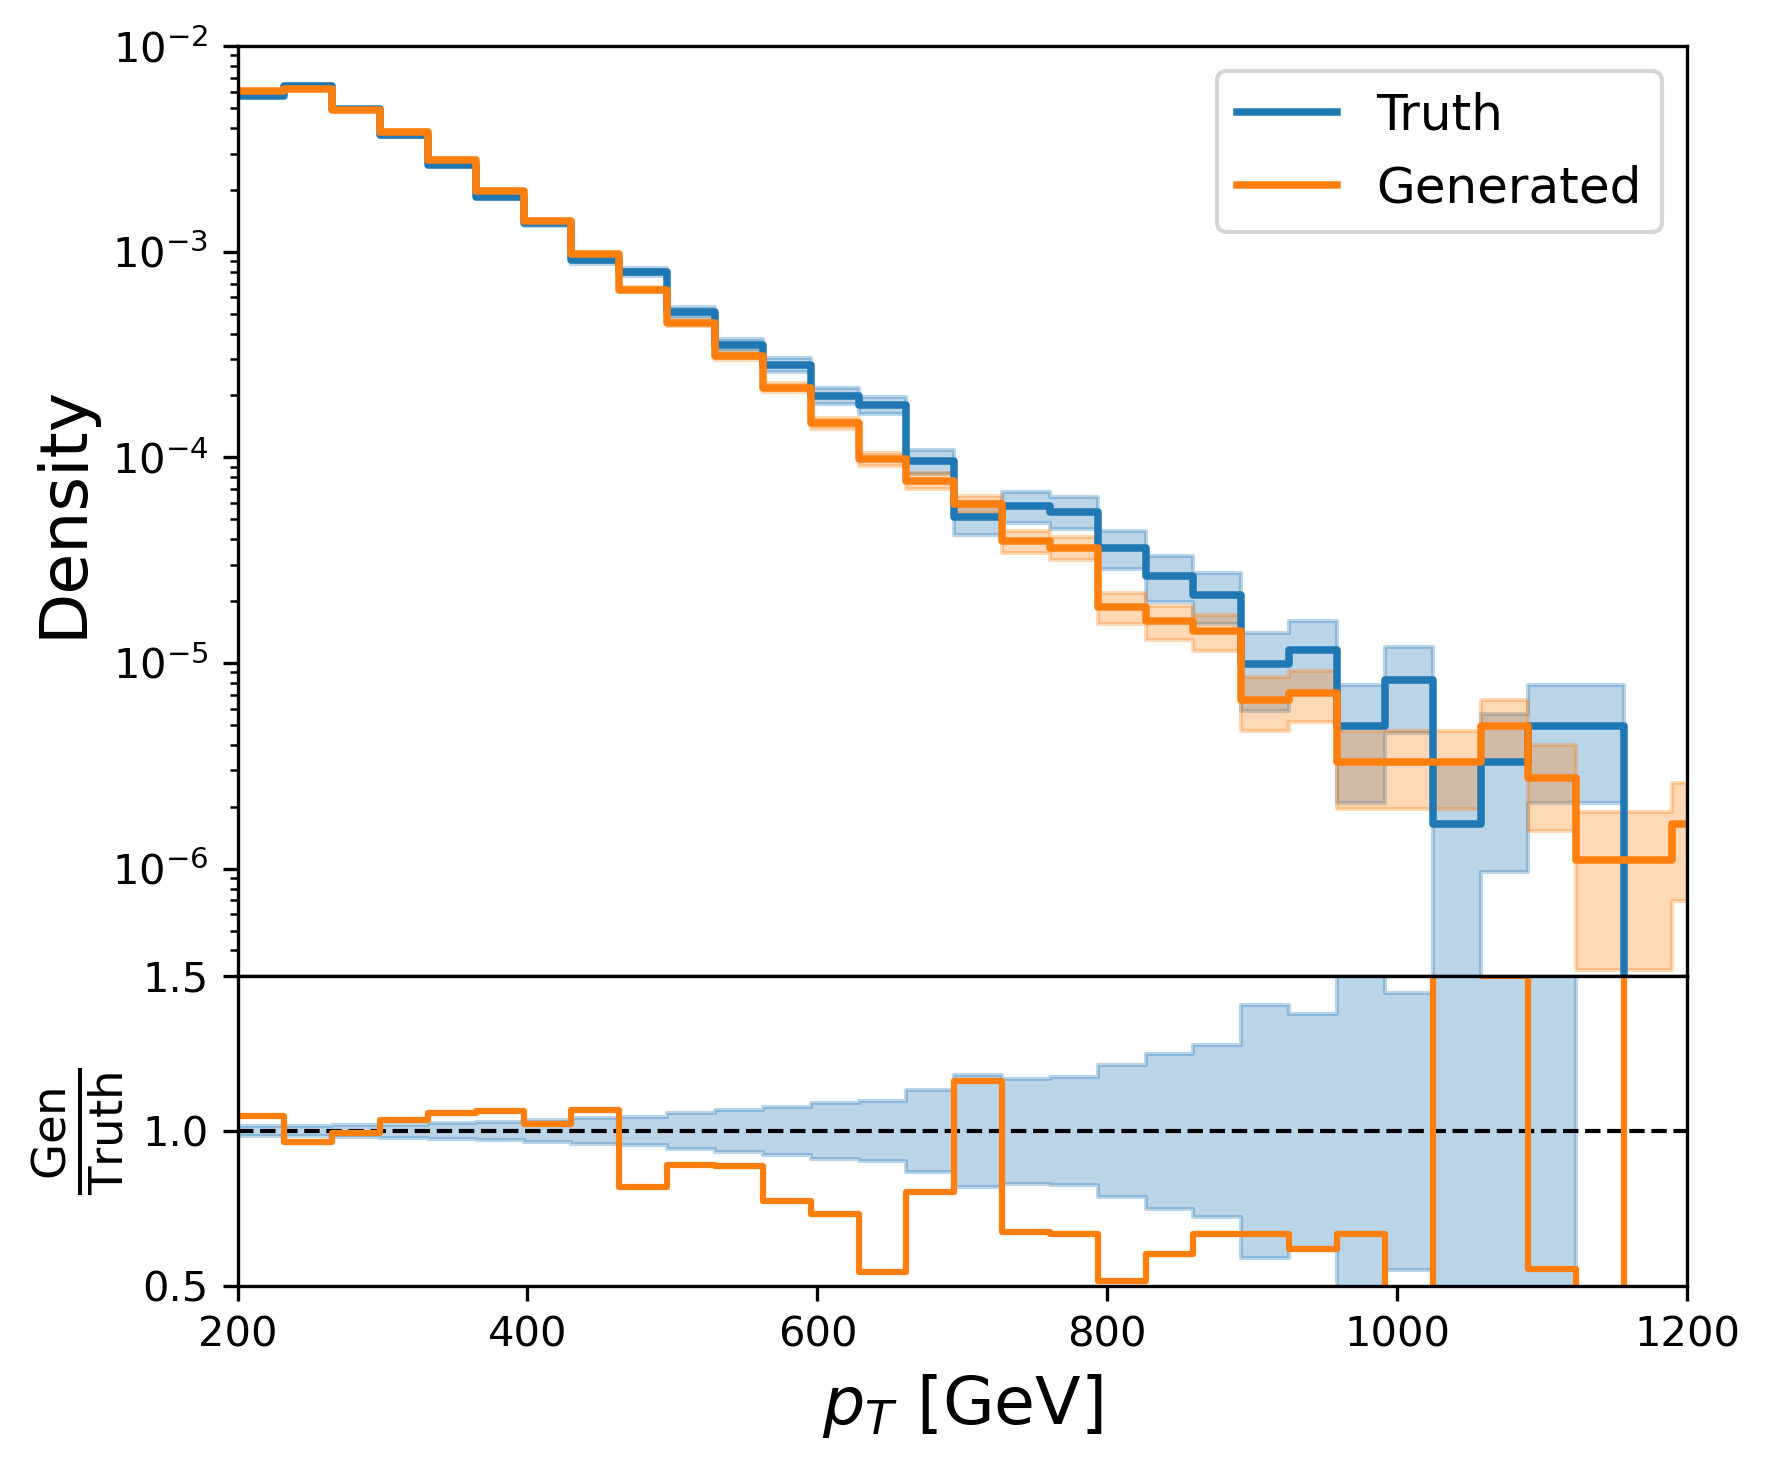

REAL DATA SHAPE:  18364 1
gen DATA SHAPE:  55092 1


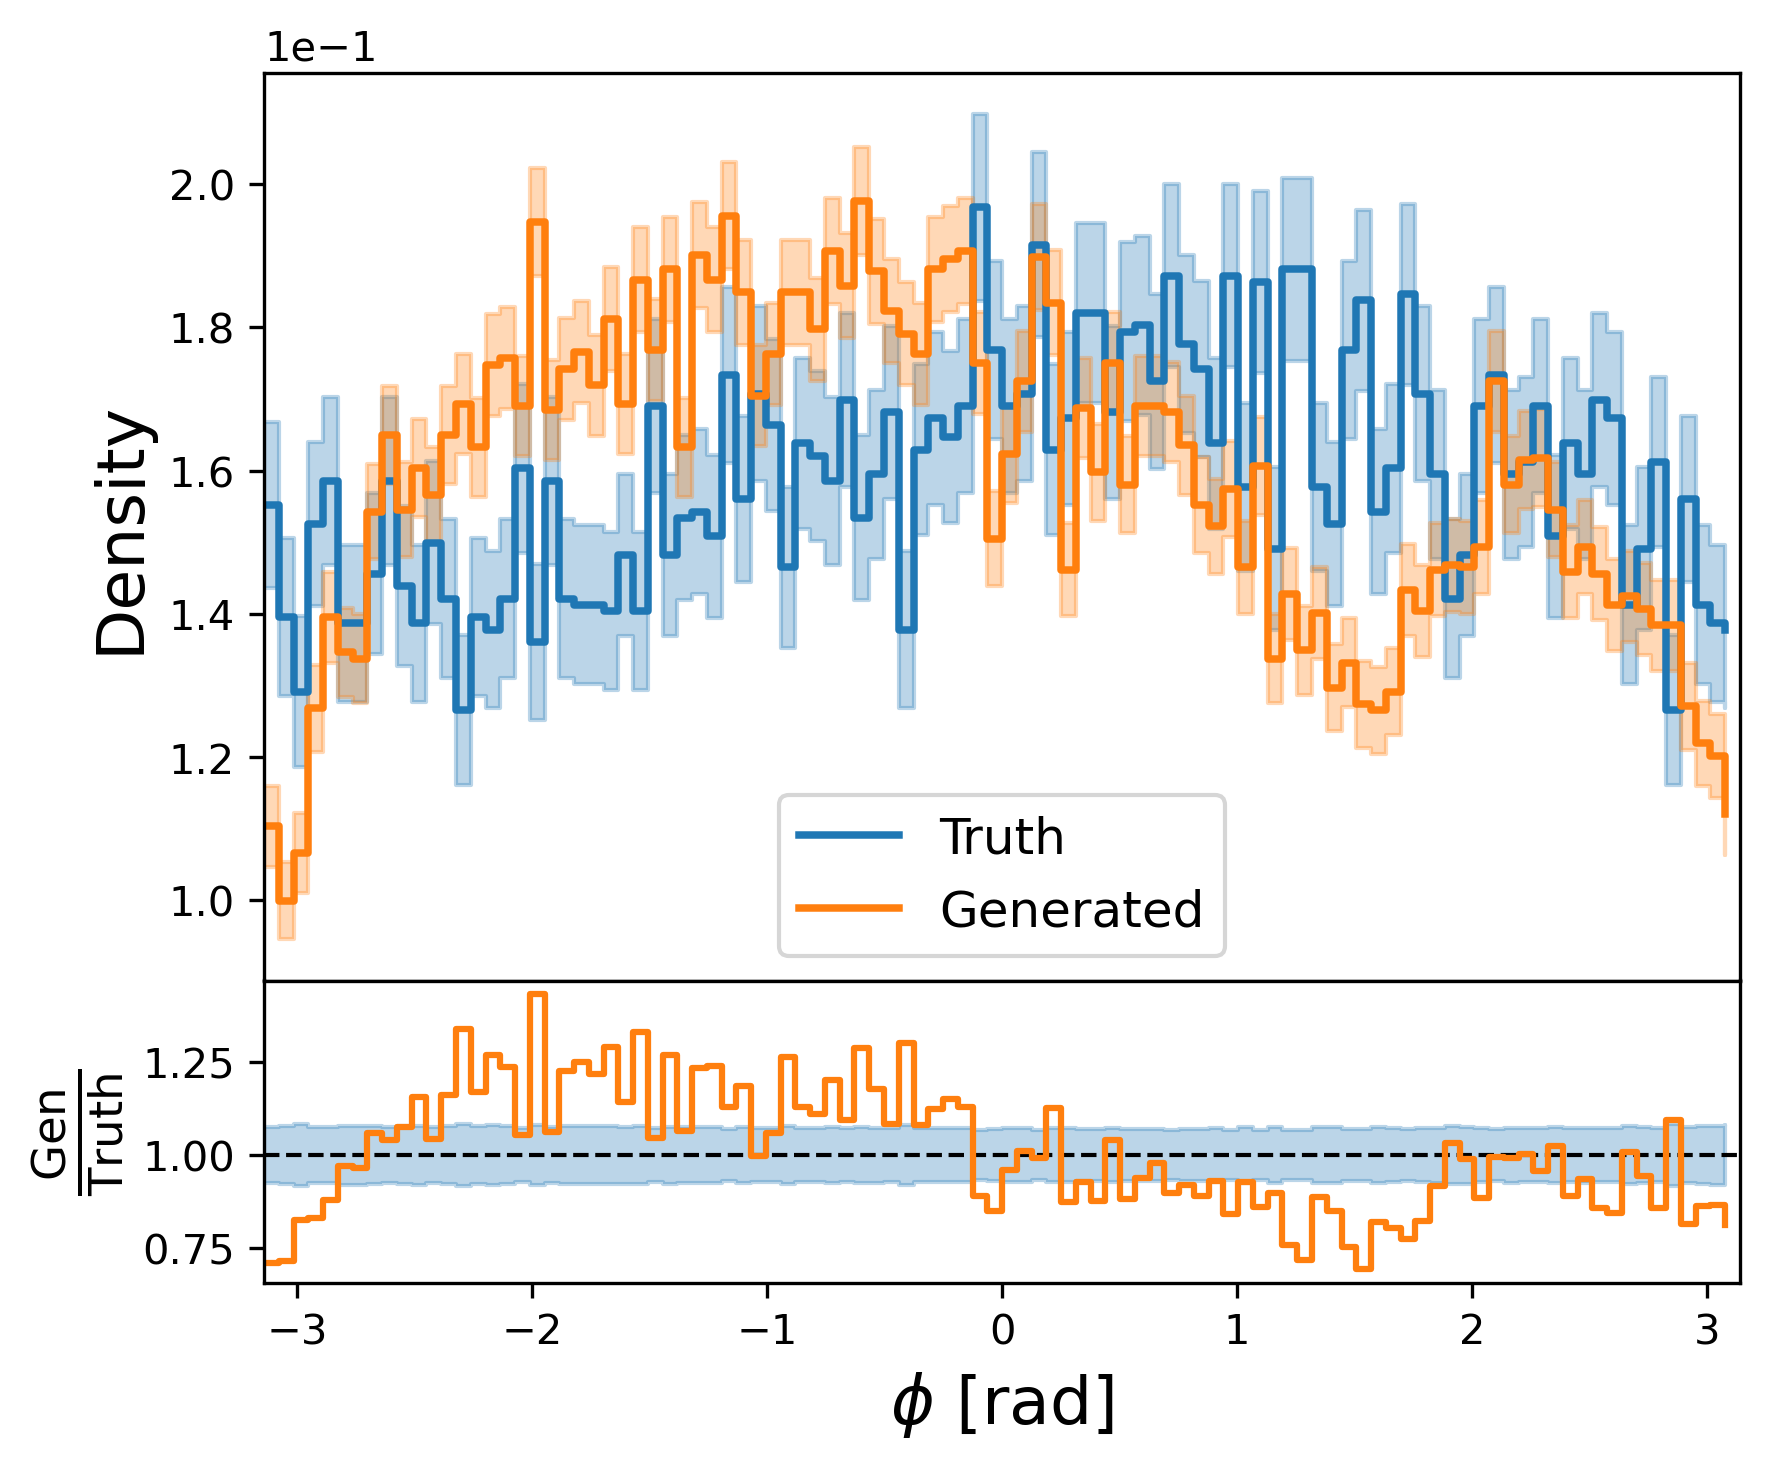

REAL DATA SHAPE:  18364 6
gen DATA SHAPE:  55092 6


/cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/models/utils.py:137: RuntimeWarning: invalid value encountered in divide
  sharex=True, figsize=(6, 5), dpi=300)


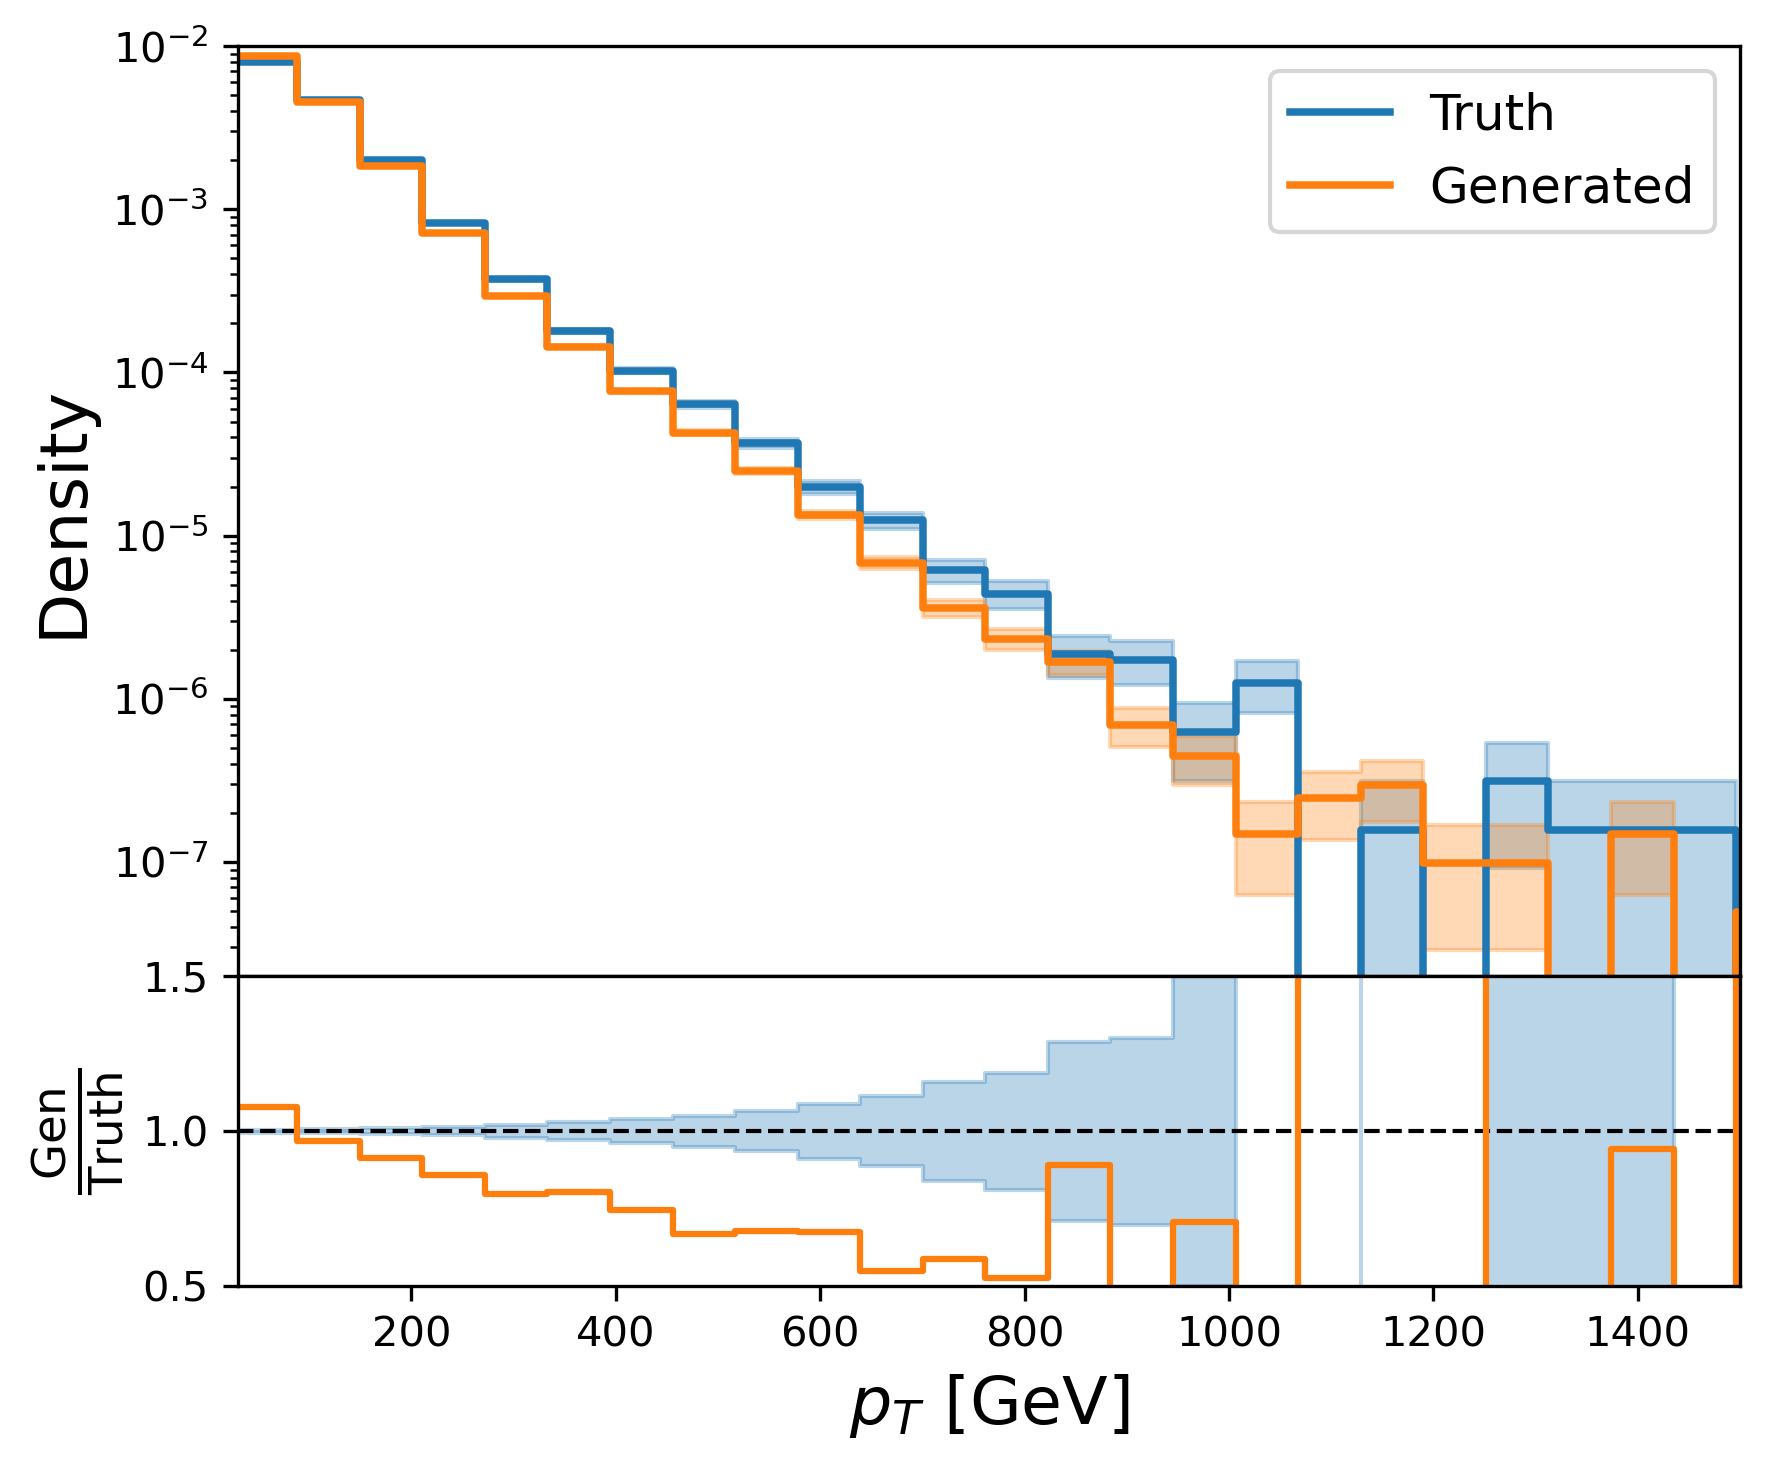

REAL DATA SHAPE:  18364 6
gen DATA SHAPE:  55092 6


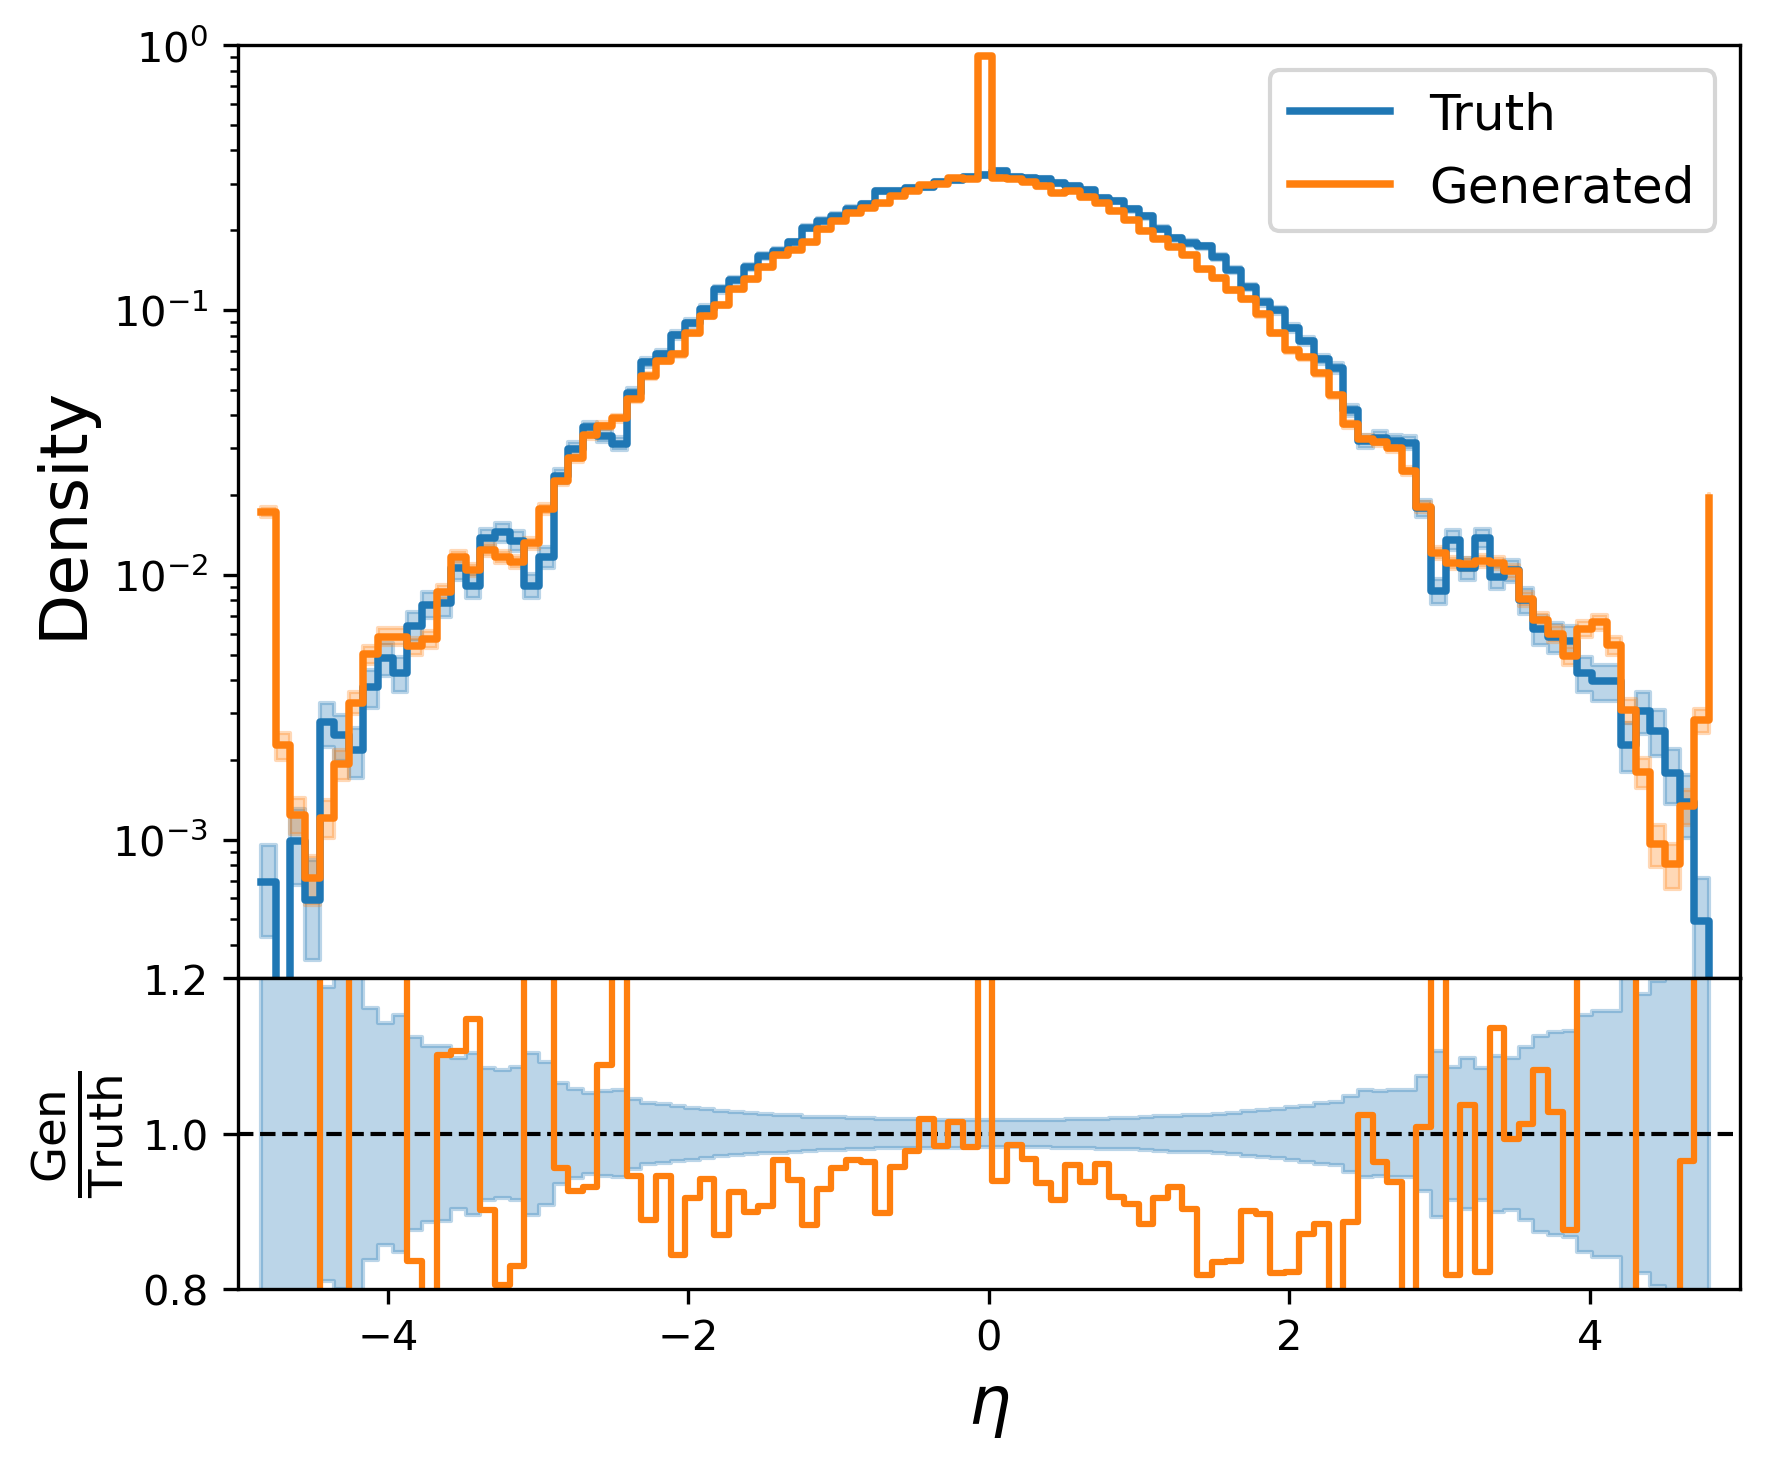

REAL DATA SHAPE:  18364 6
gen DATA SHAPE:  55092 6


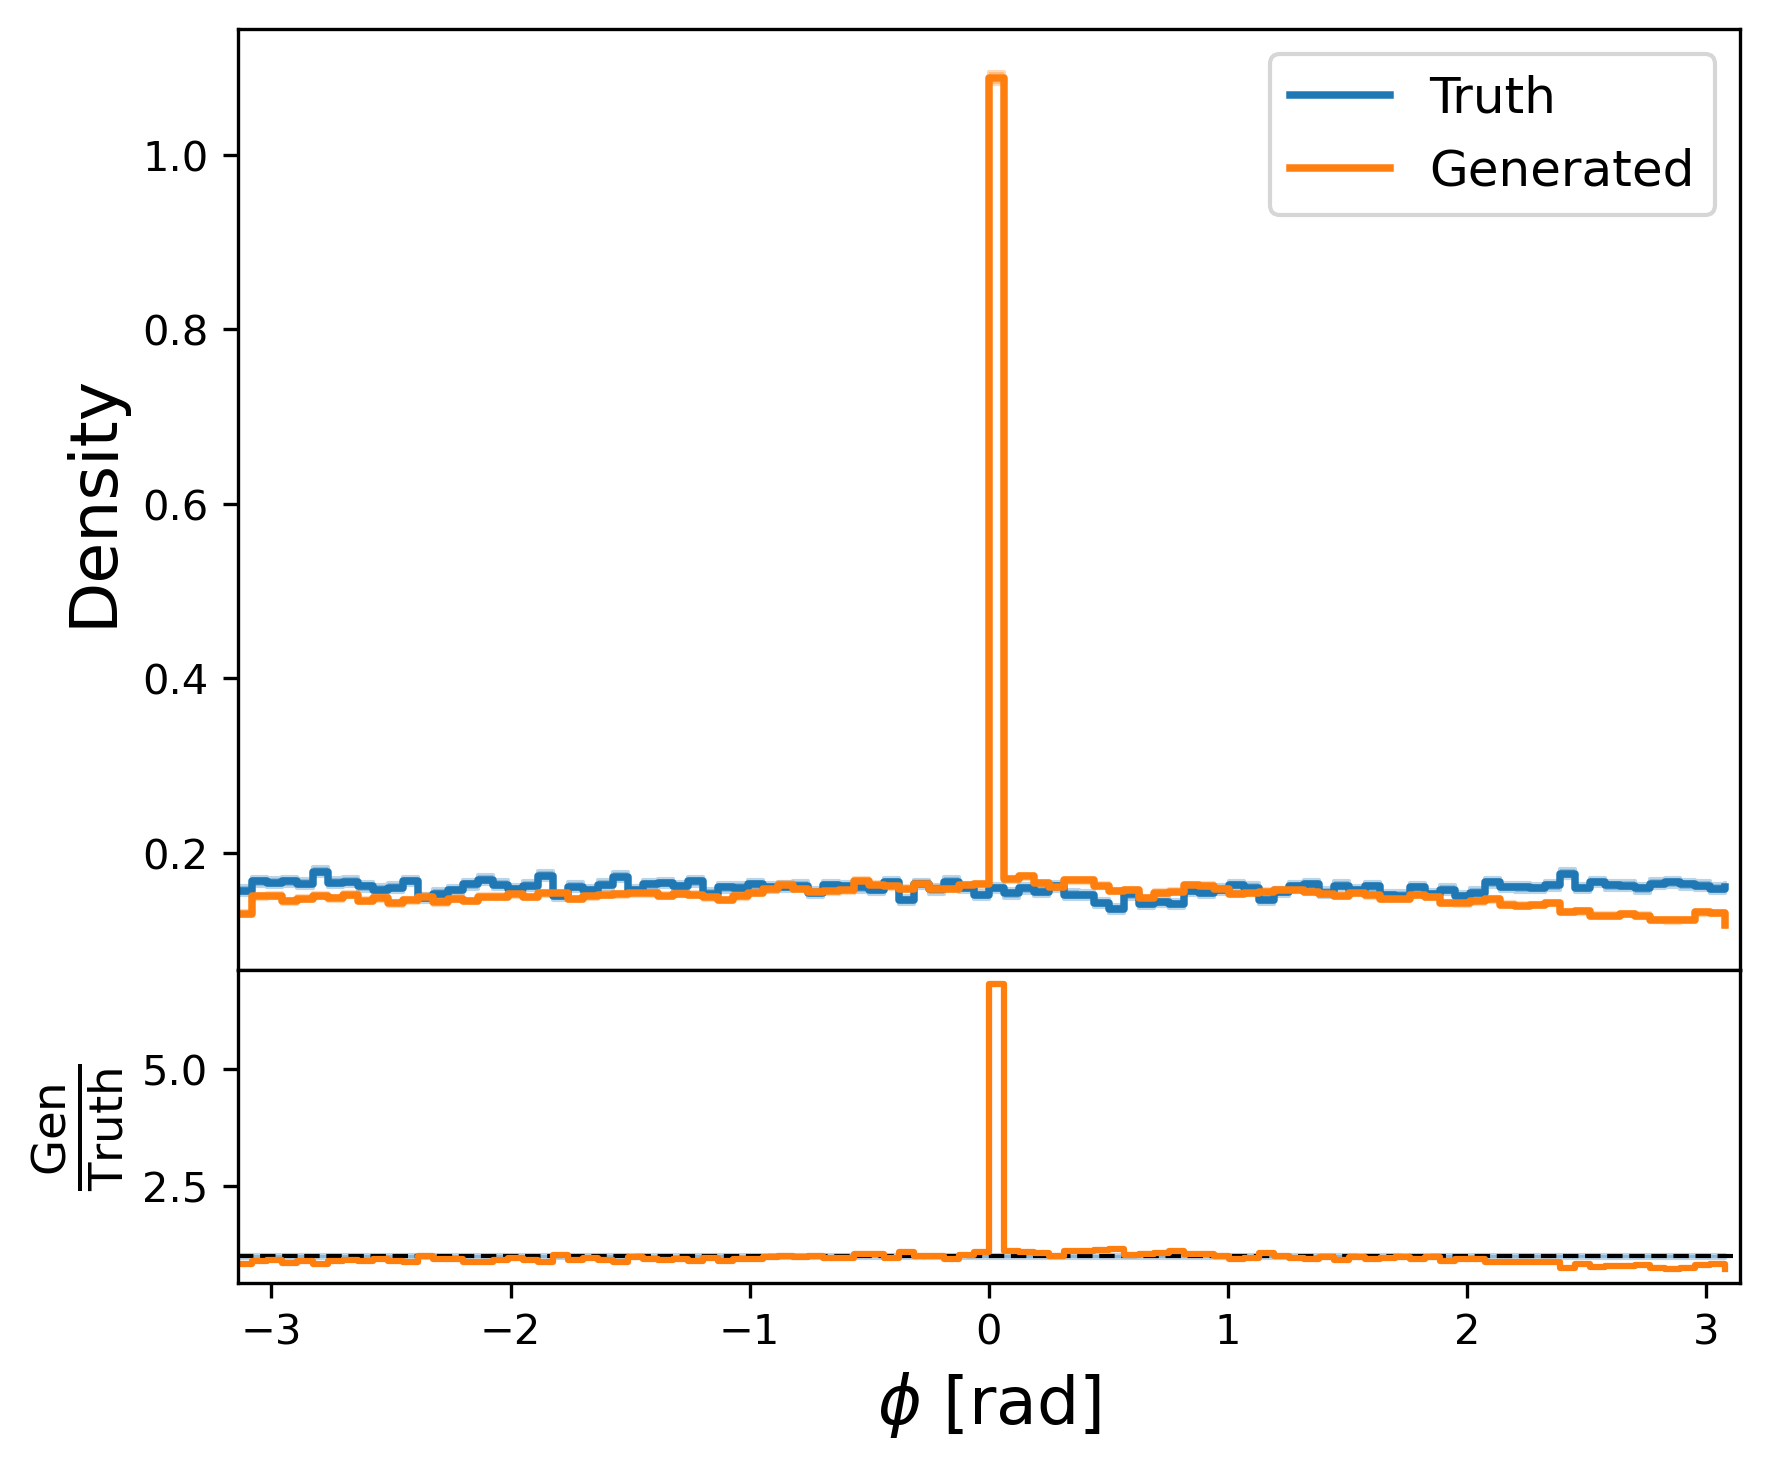

In [56]:
full_loader = DataLoader(
    combined_dataset_valid,
    batch_size = 20000,
    shuffle = False,
    num_workers = 0,
    pin_memory = True,
)

full_batch = next(iter(full_loader))
full_batch = CFMSamplingCallback.move_batch_to_device(full_batch, model.device)
print(f'Number of batches: {len(full_loader)}')
print(f"batch_size: {len(full_batch['hard']['data'][0])}")
# Get the reco mask for the same index.
real_data_full = full_batch["reco"]["data"]
real_mask_full = full_batch["reco"]["mask"]

# ========== MET ==========
compare_distributions(model, real_data_full, samples_full,
                                 ptype_idx=1,
                                 feat_idx=0,
                                 feat_name=r"$p_T$ [GeV]",
                                 preprocessing=combined_dataset.reco_dataset.preprocessing,
                                 real_mask=real_mask_full,
                                 log_scale=True,
                                 nbins=100)
compare_distributions(model, real_data_full, samples_full,
                                 ptype_idx=1,
                                 feat_idx=1,
                                 feat_name=r"$\phi$ [rad]",
                                 preprocessing=combined_dataset.reco_dataset.preprocessing,
                                 real_mask=real_mask_full,
                                 nbins=100)

# ========= JETS =========
compare_distributions(model, real_data_full, samples_full,
                                 ptype_idx=0,
                                 feat_idx=0,
                                 feat_name=r"$p_T$ [GeV]",
                                 preprocessing=combined_dataset.reco_dataset.preprocessing,
                                 real_mask=real_mask_full,
                                 log_scale=True,
                                 nbins=100)
compare_distributions(model, real_data_full, samples_full,
                                 ptype_idx=0,
                                 feat_idx=1,
                                 feat_name=r"$\eta$",
                                 preprocessing=combined_dataset.reco_dataset.preprocessing,
                                 real_mask=real_mask_full,
                                 log_scale=True,
                                 nbins=100)
compare_distributions(model, real_data_full, samples_full,
                                 ptype_idx=0,
                                 feat_idx=2,
                                 feat_name=r"$\phi$ [rad]",
                                 preprocessing=combined_dataset.reco_dataset.preprocessing,
                                 real_mask=real_mask_full,
                                 nbins=100)

In [ ]:
# Callbacks to make plots within comet
bias = BiasCallback(
    dataset = combined_dataset,               # dataset on which to evaluate bias
    preprocessing = combined_dataset.reco_dataset.preprocessing, # preprocessing pipeline to draw raw variables
    N_sample = 100,                                 # number of samples to draw
    steps = 20,                                     # Number of bridging steps
    store_trajectories = False,                     # To save trajectories plots
    frequency = 50,                                 # plotting frequency (epochs)
    raw = True,
    bins = 101,                                      # 1D/2D plot number of bins
    points = 20,                                    # Number of points for the quantile
    log_scale = True,                               # log
    batch_size = 1000,                              # Batch size to evaluate the dataset (internally makes a loaded)
    N_batch = 1,                                   # Stop after N batches (makes it faster)
    suffix = 'ttH',                                 # name for plots
    label_names = {                             # makes nicer labels
        'pt' : 'p_T',
        'eta' : '\eta',
        'phi' : '\phi',
    },
)

sampling = SamplingCallback(
    dataset = combined_dataset,           # dataset to check sampling
    preprocessing = combined_dataset.reco_dataset.preprocessing, # preprocessing pipeline
    idx_to_monitor = [1,2,3,4,5,6,7,8,9,10],               # idx of events in dataset to make plots with
    N_sample = 10000,                          # number of samples to draw
    steps = 20,                                     # Number of bridging steps
    store_trajectories = False,                     # To save trajectories plots
    frequency = 50,                             # plotting frequency (epochs)
    bins = 31,                                  # 1D/2D plot number of bins
    log_scale = True,                           # log
    label_names = {                             # makes nicer labels
        'pt' : r'$p_T$ [GeV]',
        'eta' : r'$\eta$',
        'phi' : r'$\phi$ [rad]',
    },
    pt_range = 200,
)

In [ ]:
samples_file = "samples.pt"
if os.path.exists(os.path.join("saved_samples", samples_file)):
    samples = load_samples(samples_file)
else:
    device = model.device
    sampling.set_idx(sampling.idx_to_monitor)
    hard_data = [d.to(device) for d in sampling.batch['hard']['data']]
    hard_mask = [m.to(device) for m in sampling.batch['hard']['mask']]
    reco_data = [d.to(device) for d in sampling.batch['reco']['data']]
    reco_mask = [m.to(device) for m in sampling.batch['reco']['mask']]

    print(f"Hard data batch size: {hard_data[0].shape[0]}")
    print(f"Reco data batch size: {reco_data[0].shape[0]}")

    with torch.no_grad():
        model = model.to(model.device)
        samples = model.sample(
                            hard_data, hard_mask,
                            reco_data, reco_mask,
                            sampling.N_sample,
                            sampling.steps,
                            sampling.store_trajectories
                        )
    save_samples(samples, samples_file)

In [ ]:
figures = sampling.make_sampling_plots(model,show=True,external_samples=samples)

In [ ]:
device=model.device

bias_samples_file = "bias_samples.pt"
if os.path.exists(os.path.join("saved_samples", bias_samples_file)):
    bias_samples = load_samples(bias_samples_file)
else:
    for batch_idx, batch in tqdm(enumerate(bias.loader),desc='Predict',disable=False,leave=True,total=min(bias.N_batch,len(bias.loader)),position=0):
        if batch_idx >= bias.N_batch:
            break

        # Get parts #
        hard_data = [data.to(device) for data in batch['hard']['data']]
        hard_mask_exist = [mask.to(device) for mask in batch['hard']['mask']]
        reco_data = [data.to(device) for data in batch['reco']['data']]
        reco_mask_exist = [mask.to(device) for mask in batch['reco']['mask']]

        print(f"Hard data batch size: {hard_data[0].shape[0]}")
        print(f"Reco data batch size: {reco_data[0].shape[0]}")

        # Sample #
        with torch.no_grad():
            bias_samples = model.sample(
                hard_data, hard_mask_exist,
                reco_data, reco_mask_exist,
                bias.N_sample,
                bias.steps,
                bias.store_trajectories,
            )
        save_samples(bias_samples, bias_samples_file)

In [ ]:
figs = bias.make_bias_plots(model,show=True,external_samples=bias_samples)